In [42]:
# import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from IPython.display import display, HTML
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import os
import numpy as np
import seaborn as sns
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
dataset_path = 'C:\\Users\\NET PC\\Desktop\\Collaborations 2025\\Dr. Leena\\Styloid_data'
# Image size and batch
img_height, img_width = 150, 150
batch_size = 32

# Initialize ImageDataGenerator with basic rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Optional: splits dataset into train and validation sets
)

# Load training data
train_data = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_data = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Print class indices
print("Class labels:", train_data.class_indices)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Class labels: {'LS - 100': 0, 'N - 100': 1, 'RLS - 100': 2, 'RS - 100': 3}


# User
yes

In [56]:
# Assistant
# First, define the correct dataset path
dataset_path = 'C:\\Users\\NET PC\\Desktop\\Collaborations 2025\\Dr. Leena\\Styloid_data'  # Replace with your actual dataset path

# Define class folders
class_names = ['LS-100', 'N-100', 'RLS0100', 'RS-100']

# Plot 1 sample image from each class
plt.figure(figsize=(10, 8))

for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    
    # Check if the folder exists before trying to access it
    if not os.path.exists(class_folder):
        print(f"Warning: Folder {class_folder} does not exist. Skipping.")
        continue
        
    image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        img_path = os.path.join(class_folder, image_files[0])  # Show the first image
        img = mpimg.imread(img_path)
        plt.subplot(2, 2, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

In [64]:
# Parameters
img_size = (224, 224)
batch_size = 32

# Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(dataset_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')
val_gen = datagen.flow_from_directory(dataset_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')

class_labels = list(train_gen.class_indices.keys())
num_classes = len(class_labels)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [66]:
from tensorflow.keras import layers, models

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [68]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

mobilenet_model = build_model(MobileNetV2, img_size + (3,), num_classes)
efficientnet_model = build_model(EfficientNetB0, img_size + (3,), num_classes)
resnet_model = build_model(ResNet50, img_size + (3,), num_classes)
custom_cnn_model = build_custom_cnn(img_size + (3,), num_classes)

models_dict = {
    "Custom CNN": custom_cnn_model,
    "MobileNetV2": mobilenet_model,
    "EfficientNetB0": efficientnet_model,
    "ResNet50": resnet_model  # Using ResNet50 in place of ResNet18
}

C:\Users\NET PC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from tensorflow.keras.utils import to_categorical  # Added import for to_categorical

results = {}

for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, epochs=5, validation_data=val_gen)

    # Predict and calculate AUC
    y_true = val_gen.classes
    y_pred = model.predict(val_gen)
    auc = roc_auc_score(to_categorical(y_true), y_pred, multi_class='ovr')
    results[name] = auc

# Display AUC Table
auc_df = pd.DataFrame.from_dict(results, orient='index', columns=['AUC-ROC'])
print(auc_df)


Training Custom CNN...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 582ms/step - accuracy: 0.3780 - loss: 1.3584 - val_accuracy: 0.2750 - val_loss: 1.3971
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - accuracy: 0.4178 - loss: 1.3076 - val_accuracy: 0.3250 - val_loss: 1.4084
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.4220 - loss: 1.2694 - val_accuracy: 0.2250 - val_loss: 1.4907
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - accuracy: 0.4663 - loss: 1.2349 - val_accuracy: 0.3125 - val_loss: 1.3260
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 471ms/step - accuracy: 0.4837 - loss: 1.1991 - val_accuracy: 0.3625 - val_loss: 1.3774
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step

Training MobileNetV2...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3092 - loss: 1.7138 - val_accuracy: 0.2250 - val_loss: 2.7434
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4517 - loss: 1.3488 - val_accuracy: 0.2375 - val_loss: 3.6449
Epoch 3/5
10/10 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


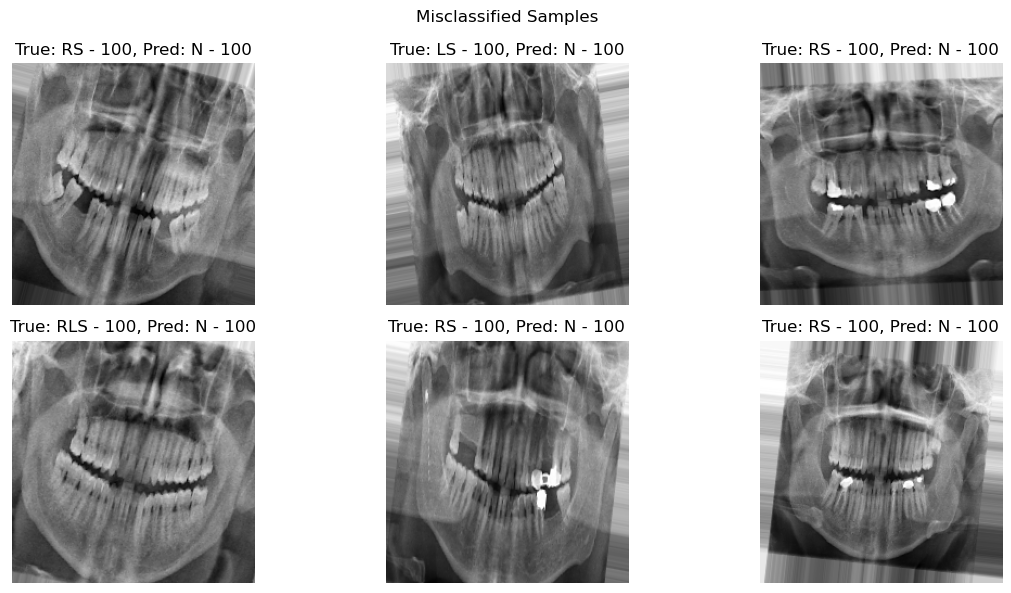

In [74]:
from tensorflow.keras.preprocessing import image

# Pick a model
model = mobilenet_model  # or any other

val_gen.reset()
x_val, y_val = next(val_gen)
preds = model.predict(x_val)
true_labels = np.argmax(y_val, axis=1)
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12, 6))
count = 0
for i in range(len(pred_labels)):
    if pred_labels[i] != true_labels[i] and count < 6:
        plt.subplot(2, 3, count+1)
        plt.imshow(x_val[i])
        plt.title(f"True: {class_labels[true_labels[i]]}, Pred: {class_labels[pred_labels[i]]}")
        plt.axis('off')
        count += 1
plt.suptitle("Misclassified Samples")
plt.tight_layout()
plt.show()

Found 400 images belonging to 4 classes.


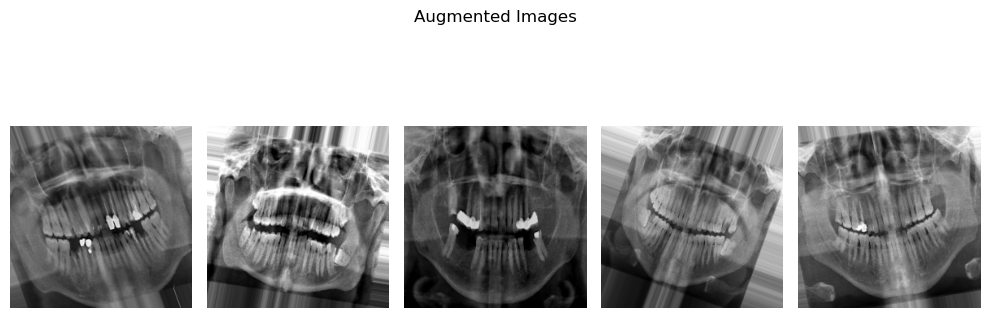

In [76]:
aug_gen = datagen.flow_from_directory(dataset_path, target_size=img_size, batch_size=1, class_mode='categorical')
x_augmented, _ = next(aug_gen)

plt.figure(figsize=(10, 4))
for i in range(5):
    x_augmented, _ = next(aug_gen)
    plt.subplot(1, 5, i+1)
    plt.imshow(x_augmented[0])
    plt.axis('off')
plt.suptitle("Augmented Images")
plt.tight_layout()
plt.show()

In [80]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 660.6 kB/s eta 0:01:00
   ---------------------------------------- 0.1/39.5 MB 787.7 kB/s eta 0:00:51
   ---------------------------------------- 0.1/39.5 MB 950.9 kB/s eta 0:00:42
   ---------------------------------------- 0.2/39.5 MB 1.1 MB/s eta 0:00:37
   ---------------------------------------- 0.2/39.5 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.2/39.5 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.2/39.5 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.2/39.5 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.4/39.5 MB 1.1 MB/s eta 0:00:37
    --------------------------------------- 0.5/39.5 MB 1.1 MB/s eta 0:00:35
    --------------------------------------- 0.5/39.5 MB 1.1 MB/s eta 0:00:35
    --------------------------------------- 0.5/39.5 MB 1.1 MB/s eta 0:00:35


# Assistant
This error occurs because the dimensions in the gradient calculation don't match what the model expects. The error specifically mentions trying to reduce along dimension 2 when the input only has 2 dimensions.

The issue is likely in the `get_heatmap` function where you're processing the gradients. The model might be expecting a different input shape or the convolutional outputs have a different structure than expected.

Would you like me to provide the corrected code?

# User
yes


The problem is likely that `conv_outputs` doesn't have the right shape for matrix multiplication with the expanded `pooled_grads`. This can happen if the convolutional layer's output has a different structure than expected.

Would you like me to provide the corrected code?

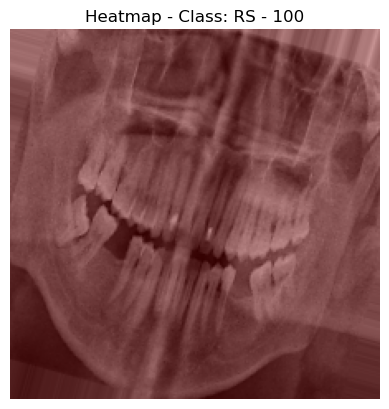

In [101]:
# Assistant
# Assistant
# Then import the required libraries
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_heatmap(model, img_array, class_index):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(index=-3).output, model.output])
    with tf.GradientTape() as tape:
        # Make sure the image has the right dimensions for the model
        # Add batch dimension if needed
        if len(img_array.shape) < 4:
            img_array = tf.expand_dims(img_array, axis=0)
            
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    # Get gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Check dimensions and adjust pooling accordingly
    # If conv_outputs is 4D (batch, height, width, channels)
    if len(conv_outputs.shape) == 4:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Create heatmap using element-wise multiplication instead of matmul
        # This avoids dimension issues with matmul
        heatmap = tf.zeros(conv_outputs.shape[1:3])
        for i in range(pooled_grads.shape[0]):
            heatmap += conv_outputs[0, :, :, i] * pooled_grads[i]
    else:
        # For other shapes, we need to reshape appropriately
        # This is a more generic approach that should work with various model architectures
        pooled_grads = tf.reduce_mean(grads, axis=0)
        
        # Reshape conv_outputs to a 2D tensor if needed
        reshaped_conv = tf.reshape(conv_outputs[0], [-1, conv_outputs.shape[-1]])
        
        # Use proper matrix multiplication with reshaped tensors
        heatmap = tf.matmul(reshaped_conv, tf.expand_dims(pooled_grads, -1))
        
        # Reshape back to original spatial dimensions if possible
        if len(conv_outputs.shape) > 2:
            # Try to infer spatial dimensions
            spatial_dims = conv_outputs.shape[1:-1]
            if len(spatial_dims) == 2:  # If we have height and width
                heatmap = tf.reshape(heatmap, spatial_dims)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# Choose one image
img, label = x_val[0:1], true_labels[0]
heatmap = get_heatmap(model, img, label)

# Superimpose
img_orig = (img[0] * 255).astype("uint8")
heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

plt.imshow(superimposed_img)
plt.title(f"Heatmap - Class: {class_labels[label]}")
plt.axis('off')
plt.show()